#The Language of Steam Game Reviews <br>
####<div style="text-align: right"> Jihee Suh </div> <br><br><br><br>
This project is done for CMSC320, Introduction to Data Science, at the University of Maryland, College Park.
***
##<div style="text-align: center"> Introduction </div> <br>
Jargon is the specialized terminology associated with a particular field or area of activity. Even if you are proficient in the English language, you may not understand the conversation of brain surgeons or rocket scientists because of jargon. Now, although it is a more approachable area, the world of video games also have their own set of jargons. "Open world", "FPS" (First Person Shooter), "NPC" (Non-Playable Character), PVP (Player vs Player), and so on. If someone who knows nothing about games reads through some game reviews, they would likely have difficulty in understanding the full meaning. Which introduces the question, how well would a machine do? <br>
In this project, I would like to analyze how a language processing model pre-trained in a more general environment will react to a smaller dataset that uses new, unfamiliar jargons in a foreign context. For the jargon dataset, I have chosen to use the data of game reviews on Steam. [Steam](https://store.steampowered.com/about/) is an online game platform where people can buy and download tens of thousands of games, most of them meant to be played on a PC. Although there are many popular video games not on Steam, Steam is still a very large hub among the gaming community, making it a good option for collecting game review data.
***
For this analysis, the following libraries will be used.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import numpy as np
from fastai import *
from fastai.text.all import *
from sklearn.model_selection import train_test_split

***
##<div style="text-align: center"> Data Curation, Parsing, and Management </div> <br>
First, we must extract and process the information from Steam's store page. Below are two functions used to execute this. ```get_n_appids``` takes the number of game ids wanted and returns that many game ids, in the order of top selling games. ```get_n_reviews``` takes the id of a game and the number of reviews wanted, and returns a list of reviews, nicely formatted and processed. Both functions send a request to a url in the Steam store and parse the returned html to extract the desired data.

In [2]:
#Data Fetching & Preprocessing
#Receives the id of a game and the number of reviews wanted, and returns a list of reviews,
#each review stored as a dictionary. May return less than n reviews if there are not enough reviews.
def get_n_reviews(appid, n=100):
    url = 'https://store.steampowered.com/appreviews/'
    reviews = []
    cursor = '*' #keeps track of where we are
    #parameters to pass to the url
    params = {
            'filter' : 'all',
            'language' : 'english'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n) #The number of reviews we are trying to get
        n -= 100

        response = requests.get(url=url+appid[0], params=params, headers={'User-Agent': 'Mozilla/5.0'}).json()
        soup = BeautifulSoup(response['html'])
        
        #get the number of all reviews for this game, and the percentage of positive reviews
        summary = BeautifulSoup(response['review_score']).find(class_="game_review_summary")
        if summary == None:
            #This means that there are 0 reviews for this game; we can return right away
            return reviews
        summary = summary['data-tooltip-html']
        percent, total = re.match("(\d+)% of the ([0-9,]*)", summary).groups()
        percent = int(percent)
        total = int(total.replace(",", ""))
        
        #The counter will store how many reviews we actually got
        counter = 0
        for box in soup.find_all("div", {"class": "review_box"}):
            counter += 1
            vote_info = box.find(class_='vote_info')
            #'helpful' and 'funny' might be None if the review has zero votes for them
            helpful = re.search("([0-9,]+) people found this review helpful", vote_info.text)
            funny = re.search("([0-9,]+) people found this review funny", vote_info.text)
            review = {
                'Game Title' : appid[1],
                'Positive Percentage' : percent,
                'Total Reviews' : total,
                'Review' : " ".join(box.find(class_='content').text.split()),
                'Recommended' : box.find(class_='title').text == "Recommended",
                'Helpful' : int(helpful.groups()[0].replace(",", "")) if helpful else 0,
                'Funny' : int(funny.groups()[0].replace(",", "")) if funny else 0
            }
            reviews.append(review)
        cursor = response['cursor']
        #If we got less than a 100 reviews, the loop is broken.
        #Either we meant to get less than a 100 reviews, in which case this is the last iteration of the loop anyway,
        #or there weren't enough reviews to retrieve, in which case there's no point trying to get more reviews.
        if counter < 100: break
    return reviews

#Returns the a list of ids of n topselling games
#Each id is a list of the actual id and the title
def get_n_appids(n=100):
    appids = []
    url = f'https://store.steampowered.com/search/?ignore_preferences=1&category1=998&filter=topsellers&page='
    page = 0

    while page*25 < n:
        page += 1
        response = requests.get(url=url+str(page), headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for row in soup.find_all(class_='search_result_row'):
            appids.append([row['data-ds-appid'], row.find(class_='title').text])

    return appids[:n]

With these functions defined, I use them to retrieve some reviews. I get the ids of a 1,000 games, and try to get 100 reviews each. I don't get 100,000 reviews, though, because many games have less than 100 reviews. Since I get the reviews grouped by game, I shuffle the dataframe before anything.

In [3]:
reviews = []
appids = get_n_appids(1000)
for appid in appids:
    reviews += get_n_reviews(appid)
    
df = pd.DataFrame(reviews)
#Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
print(df.dtypes)

(14971, 7)
Game Title             object
Positive Percentage     int64
Total Reviews           int64
Review                 object
Recommended              bool
Helpful                 int64
Funny                   int64
dtype: object


Here's what the data looks like.

In [4]:
df.head(5)

,Game Title,Positive Percentage,Total Reviews,Review,Recommended,Helpful,Funny
0,Little Nightmares II,95,6591,"Creepy, atmospheric and often oppressive adventure-puzzle-horror game. Very dark & depressing theme. Almost all sections of the game are fair and well executed, occasional controlling clunkiness aside. Very strong recommendation. Looks really nice.",True,2,0
1,Total War™: ROME II - Emperor Edition,82,22583,I think I'm getting the hang of it.,True,5,18
2,Resident Evil 7 Biohazard,93,13857,"just recommending one of the best RE, play it or die tryin'",True,0,0
3,Wargame: Red Dragon,88,6168,I've spent so many hours playing this game. Great. I like the single player mode. There is nothing to complain about the AI.,True,5,2
4,Sid Meier's Civilization® V,96,66988,"good game,extremely replayable. if it gets boring up the difficulty. havnt played enough to give a full opinion but ill try my best",True,3,0


We can already see that there are lots of variations in the data: There's a review of just one quote, and then there's a review that analyzes game mechanics, and then another one of just sentiment. It will be interesting to see how predictable (or unpredictable) the data is.
***

##<div style="text-align: center"> Exploratory Analysis </div> <br>
Since it is not humane to make anyone read through this entire dataset, we need some visuals that can succintly summarize the data. Let us first look at the text of the review itself. Below is a wordcloud of the reviews.

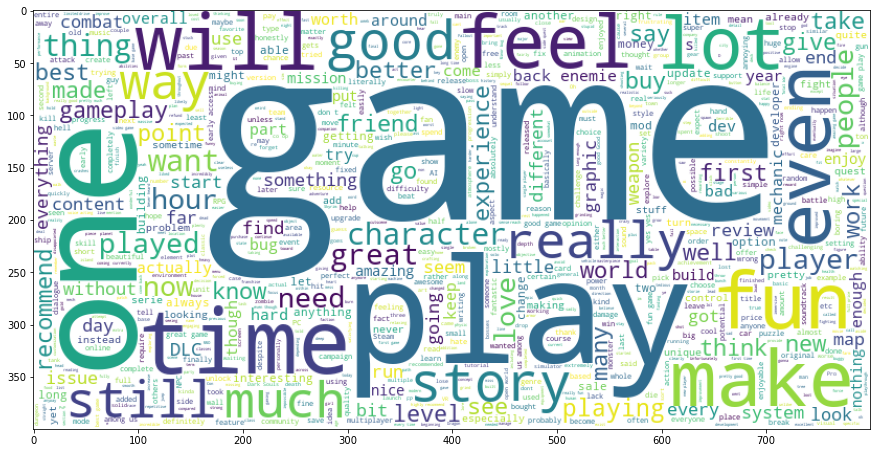

In [5]:
wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=5000).generate(" ".join(df['Review'].array))
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(wordcloud)
plt.show()

There are a lot of common words, like one, even, feel, make, and so on. But at the very center, there is the word "game", as might be expected. There are also many evaluative words, like good / great / better / best / fun / recommend and so on. And finally, there are some words that seem specific to this context like was desired- character, gameplay, item, graphic, DLC, and so on.

Next, we will take a look at some of the other columns, and see how they are related to each other. To be exact, I would like to see if a review is more likely to get votes for being helpful or funny if they agree with the overall opinion. There are two plots below, one for 'helpful' votes and one for 'funny' votes. Each plot is a scatter plot with blue dots for reviews that recommend the game, and orange dots for reviews that don't. The x-axis plots the percentage of positive reviews on the game, the overall opinion, and the y-axis plots the ratio of helpful / funny votes to the total number of reviews. I chose to use the ratio and not the raw number of votes because I expect that the magnitude of the game's audience will affect the number of votes, and so it should be appropriately discounted.

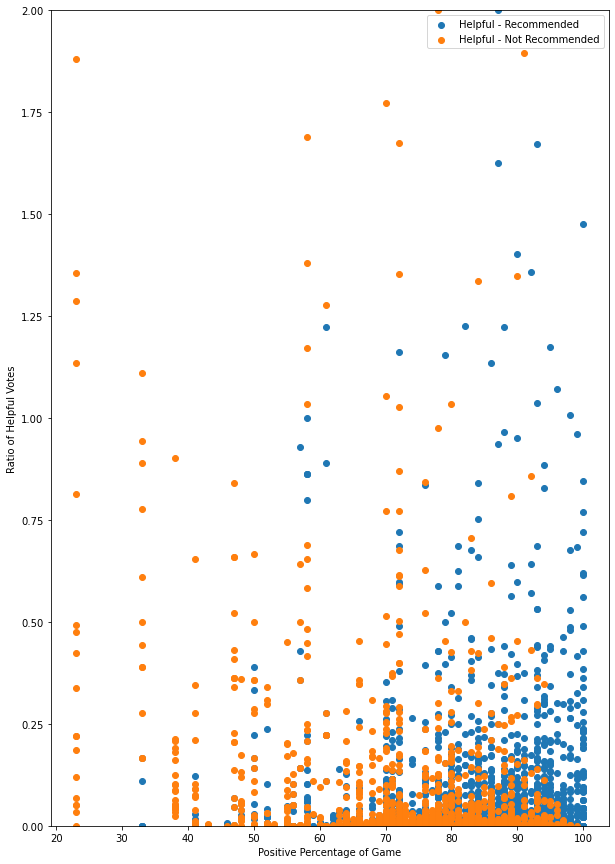

In [6]:
fig, ax = plt.subplots(figsize=(10, 15))
rec = df[df['Recommended'] == True]
not_rec = df[df['Recommended'] == False]
ax.scatter(x=rec['Positive Percentage'], y=rec['Helpful']/rec['Total Reviews'], label="Helpful - Recommended")
ax.scatter(x=not_rec['Positive Percentage'], y=not_rec['Helpful']/not_rec['Total Reviews'], label="Helpful - Not Recommended")
plt.ylim(0, 2)
plt.legend()
plt.xlabel("Positive Percentage of Game")
plt.ylabel("Ratio of Helpful Votes")
plt.show()

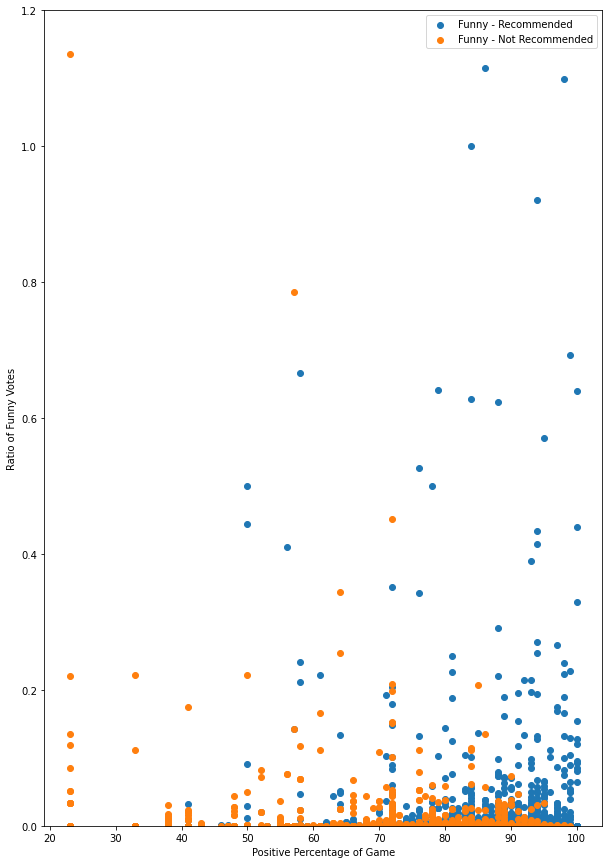

In [7]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.scatter(x=rec['Positive Percentage'], y=rec['Funny']/rec['Total Reviews'], label="Funny - Recommended")
ax.scatter(x=not_rec['Positive Percentage'], y=not_rec['Funny']/not_rec['Total Reviews'], label="Funny - Not Recommended")
plt.ylim(0, 1.2)
plt.legend()
plt.xlabel("Positive Percentage of Game")
plt.ylabel("Ratio of Funny Votes")
plt.show()

Although the variance is large even among reviews that have the same opinion on the same game, we can observe a weak correlation- that reviews that agree with the overall are slightly more likely to get votes. The correlation seems stronger for funny votes, where 50~60% seems to be the approximate boundary for positive reviews dominate votes, compared to helpful votes, where there are still highly voted negative reviews even up to around 90%.

***
##<div style="text-align: center"> Hypothesis Testing and Analysis </div> <br>
Now I will use a pretrained natural language processing (NLP) model to analyze and predict the data. The model used here is based on the ULMFit model, which you can read more about [here](https://arxiv.org/abs/1801.06146). I used the pretrained version provided in the fastai library, and for a more detailed tutorial on its usage you can reference the relevant documentation [here](https://docs.fast.ai/tutorial.text.html). This model was trained on Wikipedia: a significantly different context from game reviews on Steam. We will see how robust this model really is.<br><br>
Now in reviews, often the title of the game is mentioned, but in a context very different from everyday life. Still, this is not really a jargon, just a proper noun. So I will try treating it differently. I will test two different models: One will erase any words associated with the game title from the review, and the other will take the game title as part of the training data. <br> <br>
As for testing performance, I will try two different approaches. One will try to predict whether or not someone recommended the game based on the contents of the review. This should be fairly easy, as a human can usually deduce whether or not a review is positive. The second approach will try to predict the number of helpful votes on a review. This will be more difficult, presumably with a lot more noise- gaining votes and popularity depends heavily on chance. To balance the difficulty, I will have the model predict a simple binary- whether or not the number of helpful votes exceed 10% of the total number of reviews. <br><br>
The two functions below process the data some more to make two versions of the review text: one erases any word that is included with the game title, and the other adds the game title to the beginning of every string. Each version is stored in its respective column, 'No Title' and 'With Title'.

In [8]:
def erase_title(row):
    return " ".join([word for word in row['Review'].split() if word not in row['Game Title'].split()])
df['No Title'] = df.apply(erase_title, axis=1)
def add_title(row):
    return row['Game Title']+" "+row['Review']
df["With Title"] = df.apply(add_title, axis=1)

The data now looks like this.

In [9]:
df.head(5)

,Game Title,Positive Percentage,Total Reviews,Review,Recommended,Helpful,Funny,No Title,With Title
0,Little Nightmares II,95,6591,"Creepy, atmospheric and often oppressive adventure-puzzle-horror game. Very dark & depressing theme. Almost all sections of the game are fair and well executed, occasional controlling clunkiness aside. Very strong recommendation. Looks really nice.",True,2,0,"Creepy, atmospheric and often oppressive adventure-puzzle-horror game. Very dark & depressing theme. Almost all sections of the game are fair and well executed, occasional controlling clunkiness aside. Very strong recommendation. Looks really nice.","Little Nightmares II Creepy, atmospheric and often oppressive adventure-puzzle-horror game. Very dark & depressing theme. Almost all sections of the game are fair and well executed, occasional controlling clunkiness aside. Very strong recommendation. Looks really nice."
1,Total War™: ROME II - Emperor Edition,82,22583,I think I'm getting the hang of it.,True,5,18,I think I'm getting the hang of it.,Total War™: ROME II - Emperor Edition I think I'm getting the hang of it.
2,Resident Evil 7 Biohazard,93,13857,"just recommending one of the best RE, play it or die tryin'",True,0,0,"just recommending one of the best RE, play it or die tryin'","Resident Evil 7 Biohazard just recommending one of the best RE, play it or die tryin'"
3,Wargame: Red Dragon,88,6168,I've spent so many hours playing this game. Great. I like the single player mode. There is nothing to complain about the AI.,True,5,2,I've spent so many hours playing this game. Great. I like the single player mode. There is nothing to complain about the AI.,Wargame: Red Dragon I've spent so many hours playing this game. Great. I like the single player mode. There is nothing to complain about the AI.
4,Sid Meier's Civilization® V,96,66988,"good game,extremely replayable. if it gets boring up the difficulty. havnt played enough to give a full opinion but ill try my best",True,3,0,"good game,extremely replayable. if it gets boring up the difficulty. havnt played enough to give a full opinion but ill try my best","Sid Meier's Civilization® V good game,extremely replayable. if it gets boring up the difficulty. havnt played enough to give a full opinion but ill try my best"


I then split the set into a training set and a test set: the model will learn with the training set, and then we will test its success with the test set. Here, I use ```stratify = df['Recommended']``` to make sure that 'Recommended' labels are well spread.

In [10]:
train, test = train_test_split(df, stratify = df['Recommended'], test_size=0.2)

We then process the relevant columns of our data so that the model will be able to read it properly. Below, you can see how the data looks after processing. Tokens are added to denote special places in text, for example ```xxbos``` marks the beginning of the text and ```xxmaj``` marks the capitalization of the next word. We make two versions of processed data, one for the version with title and one for the version with no title.

In [11]:
dls_with = TextDataLoaders.from_df(train, text_col='With Title', label_col='Recommended')
dls_no = TextDataLoaders.from_df(train, text_col='No Title', label_col='Recommended')
dls_with.show_batch()

,text,category
0,xxbos xxmaj holdfast : xxmaj nations xxmaj at xxmaj war xxmaj average no / small reg enjoyer : xxrep 8 ⣿ ⡿ ⠿ xxrep 3 ⠛ ⠋ ⠉ ⠈ xxrep 4 ⠉ ⠛ ⠻ ⢿ xxrep 12 ⣿ ⡿ ⠋ ⠁ xxrep 15 ⠀ ⠉ ⠛ ⢿ xxrep 8 ⣿ ⡏ ⣀ xxrep 7 ⠀ ⣀ xxrep 3 ⣤ ⣄ ⡀ xxrep 7 ⠀ ⠙ ⢿ xxrep 5 ⣿ ⢏ ⣴ ⣿ ⣷ xxrep 5 ⠀ ⢾ xxrep 6 ⣿ ⡆ xxrep 7 ⠀ ⠈ xxrep 4 ⣿ ⣟ ⣾ ⣿ ⡟ ⠁ xxrep 5 ⠀ ⢀ ⣾ xxrep 5 ⣿ ⣷ ⢢ xxrep 7 ⠀ ⢸ xxrep 5 ⣿ ⣟ ⠀ ⡴ ⠄ xxrep 6 ⠀ ⠙ ⠻ xxrep 4 ⣿ ⣷ ⣄ xxrep 7 ⠀ xxrep 4 ⣿ ⠟ ⠻ xxrep 10 ⠀ ⠶ ⢴ xxrep 5 ⣿ ⣧ xxrep 6 ⠀ ⣿ ⣿ ⣁ ⡀ ⠀ ⠀,True
1,"xxbos xxmaj stranded xxmaj deep i wanted to give xxmaj stranded xxmaj deep a try for the longest time . xxmaj the introduction of xxmaj coop then finally made us test it out . xxmaj in it 's current state however , i can not recommend it . xxmaj there are tons of flaws with the game : from little imperfections , over questionable game design choices , to crippling xxunk is a full - length review . xxmaj you can heavily xxunk the read by stopping after the personal gameplay story i put at the top , as it should be enough to deliver the message . xxmaj if you are still xxunk , you can afterwards read up on the other topics making this game unenjoyable to play , which ca nt be delivered in such a xxunk introduction : the game starts with your plane crashing .",False
2,"xxbos xxmaj middle - earth ™ : xxmaj shadow of xxmaj war ™ middle - earth : xxmaj shadow of xxmaj war ( xxunk continue playing as xxmaj talion as you set out to conquer xxmaj mordor from the evil overlord xxmaj xxunk . xxmaj if you played xxmaj shadow of xxmaj mordor you will xxunk a lot of returning similarities in game mechanics such as stealth attacks , range attacks with your bow and various skills you can use . xxmaj there is a leveling system that can take you all the way up to level 80 and you get a xxunk with each level which you can invest in an ability or an upgrade for an ability . xxmaj this greatly expands the previous game 's system as you can create your own playstyle with lots of skills you can swap out to exploit enemy weaknesses . xxmaj",True
3,"xxbos xxmaj rune xxmaj factory 4 xxmaj special xxmaj other , long - time fan reviews of this game will give you a far better breakdown of what makes this game so fantastic , but xxmaj i 'll share something else from a somewhat different perspective in case there 's anyone out there like me considering picking this one xxunk - xxmaj if you 're coming to this series from xxmaj stardew xxmaj valley , this is my condensed take on it : xxmaj playing this , you can see the xxup xxunk that was used to create xxmaj stardew xxmaj valley , and xxup sv is an absolutely fantastic game . xxmaj however , xxmaj rune xxmaj factory 4 xxmaj special , just in my opinion , does a plethora of little things better than xxup sv , even in spite of it being quite a bit older .",True
4,"xxbos xxup ace xxup combat ™ 7 : xxup skies xxup unknown xxmaj summary : xxmaj another good game in the xxmaj ace xxmaj combat series that has beautiful graphics and gameplay , but suffers from a small amount of shaky storytelling . xxmaj overall xxunk / xxunk into xxmaj detail : xxmaj gameplay , is solid . xxmaj it 's an arcade flight game at its core and the designers and developers did a great job at making the aircraft realistic enough to be believable while they fly at constant high speeds , pull crazy maneuvers , and engage in high octane xxunk . xxmaj aircraft are able to pull unrealistic amounts of xxmaj g - forces in high speed maneuvers , but it 's ok because the game makes it fun with high speed xxunk where you choose your ideal weapons from the vast array of weapons your",True
5,"xxbos xxmaj police xxmaj simulator : xxmaj patrol xxmaj officers xxmaj the xxmaj good , xxmaj bad , and xxmaj ugly of xxup ps : po [ beta xxmaj player / xxunk like to start off by saying , as a veteran of xxup lspd : fr , this might be the best chance of a standalone & simplistic style of xxup leo simulation . xxmaj while still in its xxunk if you are interested , or a current player 

Then we making a learning model for each version, and fit both of them for a single cycle, with a learning rate of 0.01.

In [12]:
learn_with = text_classifier_learner(dls_with, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [13]:
learn_no = text_classifier_learner(dls_no, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [14]:
learn_with.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.429104,0.338757,0.857620,05:21


In [15]:
learn_no.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.416833,0.393456,0.827557,05:04


Then I test the models on the test set. I set ```target``` as the correct answer, and ```preds_with``` and ```preds_no``` each contain the prediction for each version of the model. I concatenate these into a single dataframe, and show the results below.

In [16]:
target = test['Recommended']
preds_with = test['With Title'].apply(learn_with.predict)
preds_no = test['No Title'].apply(learn_no.predict)

In [17]:
preds = pd.concat([target, preds_with, preds_no], axis=1)
preds.head(5)

,Recommended,With Title,No Title
2842,True,"(True, TensorText(1), [TensorText(0.0062), TensorText(0.9938)])","(True, TensorText(1), [TensorText(0.0116), TensorText(0.9884)])"
6639,True,"(True, TensorText(1), [TensorText(0.0887), TensorText(0.9113)])","(True, TensorText(1), [TensorText(0.0152), TensorText(0.9848)])"
12034,True,"(True, TensorText(1), [TensorText(0.1736), TensorText(0.8264)])","(True, TensorText(1), [TensorText(0.0529), TensorText(0.9471)])"
3633,True,"(True, TensorText(1), [TensorText(0.1209), TensorText(0.8791)])","(True, TensorText(1), [TensorText(0.0792), TensorText(0.9208)])"
13069,False,"(True, TensorText(1), [TensorText(0.0784), TensorText(0.9216)])","(True, TensorText(1), [TensorText(0.0207), TensorText(0.9793)])"


```preds_with``` and ```preds_no``` contain a tuple for each data point. The first element is the prediction, the second is the numeral version of it in its internal processings, and the third and fourth are the probabilities the model assigned to each possible answer. Here, we will discard everything but the first element and calculate the accuracy of the model with it.

In [18]:
total = len(preds.index)
with_score = 0
no_score = 0
for index, row in preds.iterrows():
    if row['Recommended'] == bool(row['With Title'][0]):
        with_score += 1
    if row['Recommended'] == bool(row['No Title'][0]):
        no_score += 1
print("With Title - Accuracy: "+str(with_score/total))
print("Without Title - Accuracy: "+str(no_score/total))

With Title - Accuracy: 0.8063439065108514
Without Title - Accuracy: 0.8063439065108514


The prediction scores are equal: showing that the pretrained model is robust against small changes. Perhaps the result may have been different if the model could accept multiple strings as variables, so that we could pass the text of the review and game title separately, but I will leave that to other projects. On the other hand, both models did quite well: they achieved @@@@@@@@@@@@@@@@@@ accuracy by fitting on just one cycle. Even though the model had to deal with unknown words and different contexts, it performed quite well. This confirms my assumption that this wouldn't be too difficult. <br><br>
Next, I will try to train the model to predict whether or not a review received helpful votes more than 10% of the total number of reviews on that game. I first make a new column to be used as the target, 'Is Helpful?'.

In [19]:
df['Is Helpful?'] = df.apply((lambda x: x['Helpful'] >= 0.1*x['Total Reviews']), axis=1)
print(df[['Total Reviews', 'Helpful', 'Is Helpful?']])

       Total Reviews  Helpful  Is Helpful?
0               6591        2        False
1              22583        5        False
2              13857        0        False
3               6168        5        False
4              66988        3        False
...              ...      ...          ...
14966           5649        0        False
14967            878        2        False
14968          23788        7        False
14969          23552        0        False
14970          17886        4        False

[14971 rows x 3 columns]


Then I split the data again, this time with ```stratify = df['Is Helpful?']``` because 'Is Helpful?' is the label that I want to be spread evenly, not 'Recommended'. Then I process the data, this time with just 'Review' because the title processing has proved to be ineffective.

In [20]:
train_helpful, test_helpful = train_test_split(df, stratify = df['Is Helpful?'], test_size=0.2)
dls = TextDataLoaders.from_df(train_helpful, text_col='Review', label_col='Is Helpful?')
dls.show_batch()

,text,category
0,xxbos aaaaaaa xxrep 3 a aa xxrep 3 a aa xxrep 6 a xxrep 8 a xxrep 3 a xxrep 5 a aaaa xxrep 3 a xxrep 12 a xxrep 4 a aaaaaaa xxrep 8 a a xxrep 4 a xxrep 15 a aaa xxrep 6 a xxrep 7 a aaaaaa xxrep 5 a aaa xxrep 3 a a xxrep 9 a xxrep 6 a a xxrep 4 a xxmaj aaa xxrep 5 a xxrep 5 a aaa xxrep 9 a xxrep 9 a xxrep 6 a a xxrep 3 a xxrep 10 a xxrep 3 a xxrep 5 a xxrep 4 a aaaaa xxrep 6 a xxrep 8 a aaaaa xxrep 7 a xxrep 4 a xxup aa xxrep 4 a xxrep 6 a xxrep 10 a aaaaaaa xxrep 3 a aa xxrep 3 a aa xxrep 6 a xxrep 8 a xxrep 3 a xxrep 5 a aaaa,False
1,"xxbos xxmaj so this august , xxmaj i ’ve bought the games on xxmaj steam , the xxup hd collection of first 3 games , xxup dmc 4 xxup se and 5 . xxmaj started from scratch , completed all the achievements , already made reviews on each games and i mostly love them ( except for 2nd one , that one is garbage ) . xxmaj especially the third one , that is one of the best games ever made and i thought to myself “ how can you top this ? ” it ’s that good . xxmaj then i started and finished the 5th game and oh my xxmaj god , this game just rocks on every possible level ! xxmaj here ’s a xxup tldr review : xxmaj basically xxmaj terminator 2 of video games , one of the best action games ever made . xxmaj",False
2,"xxbos xxmaj stating ' no ' on the recommendation is probably one of the most difficult things i have done , its also perhaps … unfair ? xxmaj since for xxmaj dragon xxmaj age fans , xxup dai is probably a game you 'll want to play at some point . xxmaj however … i ca n't . i just ca n't recommend xxup dai as an xxup rpg . xxmaj so xxmaj i 'm going to do a full explanation on my reasons . xxmaj as with most reviews xxmaj i 'll keep spoilers to a minimum , but i wo n't hesitate to xxunk or state certain things if its required . xxmaj if you are not okay with that , continue scrolling . xxmaj thank xxunk gon na start off with the gameplay , mechanics , that sort of thing . xxmaj in a word - xxmaj",False
3,"xxbos xxmaj this game sets critical xxunk theory back several decades and xxmaj i 'm here for it . xxmaj you play some xxunk looking xxunk xxunk an absurd slab of meat that flies in the face of the xxmaj xxunk xxmaj xxunk . i presume that 's why you 're in some banana republic where international law ca n't hold you accountable for your xxunk use of a weapon of mass destruction . xxmaj have you ever seen the movie "" xxunk 's ? "" xxmaj of course not ; you 're a xxunk . xxmaj if "" xxunk 's "" was a person , he 'd be the protagonist . xxmaj xxunk ' on babes . xxmaj forced xxunk . xxmaj his dong leads him through the world like a blind man 's xxunk . xxmaj he 's obnoxious and full of himself , but occasionally he 'll",True
4,"xxbos xxmaj what 's there to say about xxmaj final xxmaj fantasy xxup xiv that you have not heard already . xxmaj it 's the critically xxunk xxup mmorpg , which has a free trial , and includes the entirety of a xxmaj real xxmaj reborn xxup and the award - winning xxmaj heavensward expansion up to level 60 with no restrictions on playtime … xxmaj bet you have not heard that one before . xxmaj and maybe you have n't , this is the copy - pasta that 's xxunk the internet and yes , it 's all true . i know of people who have sunk way over 1 . xxrep 3 0 hours into the free trial alone and believe it or not , still not being done with everything you can do in it . xxmaj with that said , what is xxmaj final xxmaj fantasy",False
5,"xxbos xxmaj let 's talk ' into xxmaj the xxmaj radius ' ; the recent 2.0 has some absolutely great features , added some annoying ones , some bad ones , and some make or breaks were left in . xxmaj the reason for me not recommending this game is because of it 's xxup current state . xxmaj with that being said give the devs some slack . xxmaj firstly removing drops from basic mobs is welcomed , but at the same time irritating due to the new mechanic ' the xxmaj tide ' . xxmaj in essence when a timer reaches 0 a wipe happens across the explorab

Then I repeat the process of making a model and training it.

In [21]:
learn_helpful = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [22]:
learn_helpful.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.222530,0.179203,0.958664,05:28


I predict the data, concatenate it with the target data, and calculate its accuracy.

In [23]:
preds_helpful = test_helpful['Review'].apply(learn_helpful.predict)

In [24]:
preds = pd.concat([test_helpful['Is Helpful?'], preds_helpful], axis=1)
preds.head(5)

,Is Helpful?,Review
10006,False,"(False, TensorText(0), [TensorText(0.9797), TensorText(0.0203)])"
7895,False,"(False, TensorText(0), [TensorText(0.9963), TensorText(0.0037)])"
7934,False,"(False, TensorText(0), [TensorText(0.9771), TensorText(0.0229)])"
2311,False,"(False, TensorText(0), [TensorText(0.9544), TensorText(0.0456)])"
11139,False,"(False, TensorText(0), [TensorText(0.9902), TensorText(0.0098)])"


In [38]:
total = len(preds.index)
score = 0
for index, row in preds.iterrows():
    if str(row['Is Helpful?']) == row['Review'][0]:
        score += 1
print("Accuracy: "+str(score/total))

Accuracy: 0.9539232053422371


On first glance, this seems amaxing: although I predicted this would be harder, this model shows an amazing accuracy of 0.95! However, this is only an illusion. Below, I calculated the percentage of 'False' predictions by the model.

In [39]:
score = 0
for index, row in preds.iterrows():
    if row['Review'][0]=="False":
        score += 1
print("Percentage of 'False' predictions: "+str(score/total))

Percentage of 'False' predictions: 1.0


Apparently, the model has defaulted to just outputing 'False' for everything! Because the prior probabilities of 'Is Helpful?' being False are so high, the model is unable to learn anything that is meaningful enough to tip that prior. <br><br>
For a slightly easier test, I will repeat the process, but with the standard being that there must be more than 10 helpful votes, not more than 10% of the total. I will test if the model can at least get an indication of a review's value, even in a different context.

In [41]:
df['Weak Helpful'] = df.apply((lambda x: x['Helpful'] >= 10), axis=1)
print(df[['Helpful', 'Weak Helpful']])

       Helpful  Weak Helpful
0            2         False
1            5         False
2            0         False
3            5         False
4            3         False
...        ...           ...
14966        0         False
14967        2         False
14968        7         False
14969        0         False
14970        4         False

[14971 rows x 2 columns]


In [42]:
train_weak, test_weak = train_test_split(df, stratify = df['Weak Helpful'], test_size=0.2)
dls_weak = TextDataLoaders.from_df(train_weak, text_col='Review', label_col='Weak Helpful')
learn_weak = text_classifier_learner(dls_weak, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn_weak.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.593405,0.566616,0.734447,05:08


In [58]:
preds_weak = test_weak['Review'].apply(learn_weak.predict)

In [59]:
preds_weak = pd.concat([test_weak['Weak Helpful'], preds_weak], axis=1)

In [60]:
total = len(preds_weak.index)
score = 0
for index, row in preds_weak.iterrows():
    if str(row['Weak Helpful']) == row['Review'][0]:
        score += 1
print("Accuracy: "+str(score/total))

Accuracy: 0.7185308848080133


In [61]:
score = 0
for index, row in preds_weak.iterrows():
    if row['Review'][0]=="False":
        score += 1
print("Percentage of 'False' predictions: "+str(score/total))

Percentage of 'False' predictions: 0.9489148580968281


We can see that although the model still did worse than predicting whether or not a review recommended its game, it did quite well: the model learned something from the text to do better than just guessing as the most likely answer.

***
##<div style="text-align: center"> Insights </div> <br>
In this project, we went through the whole data science pipeline: We identified a data source, collected and preprocessed it, did some exploratory data analysis, came up with some hypotheses and tested it through machine learning, and now we are at the final phase of drawing insights.<br><br>
We saw that with a good pretrained NLP model could reasonably adjust to a new dataset with unfamiliar vocabulary and specific contexts. After fitting for just one cycle, the model could predict the recommendation of a review with 80.6% accuracy; and it could predict if a review had more than 10 helpful votes with 71.8% accuracy. This accuracy can likely be improved further with more iterations in training. <br><br>
I hope that this project has helped you understand how to work through the data science pipeline, and has shown you the robustness and accessibility of modern NLP models. I hope this will encourage more people to utilize NLP in their applications when dealing with text: even if you are working in a very specific field, this project has shown that modern NLP models can adjust surprisingly quickly.